In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Load the Dataset

In [11]:
file_path = "Business_Performance_09-01-2025_09-30-2025_10-09-2025_13-16-30.xlsx"
df = pd.read_excel(file_path)

df.head()

,Date Range,Revenue,Orders,Units Sold,Customer Visits,Conversion Rate
0,09/01/2025,32971.54,65,73,9151,0.005901
1,09/02/2025,30084.17,70,83,7275,0.006048
2,09/03/2025,3555.82,41,41,6250,0.003040
3,09/04/2025,7172.08,42,42,6124,0.003266
4,09/05/2025,4593.71,36,36,5709,0.003854


## Data cleaning and preprocessing
Prophet needs columns:
- ds → date column
- y → target column (here “Units Sold”)

In [12]:
# Clean column names
df.columns = df.columns.str.strip()

# Convert 'Date Range' to datetime
df['Date Range'] = pd.to_datetime(df['Date Range'])

# Remove $ and , from Revenue
df['Revenue'] = df['Revenue'].replace(r'[\$,]', '', regex=True).astype(float)

# Remove % from Conversion Rate
# df['Conversion Rate'] = df['Conversion Rate'].replace(r'[%]', '', regex=True).astype(float) / 100

### Data Trend Visualization

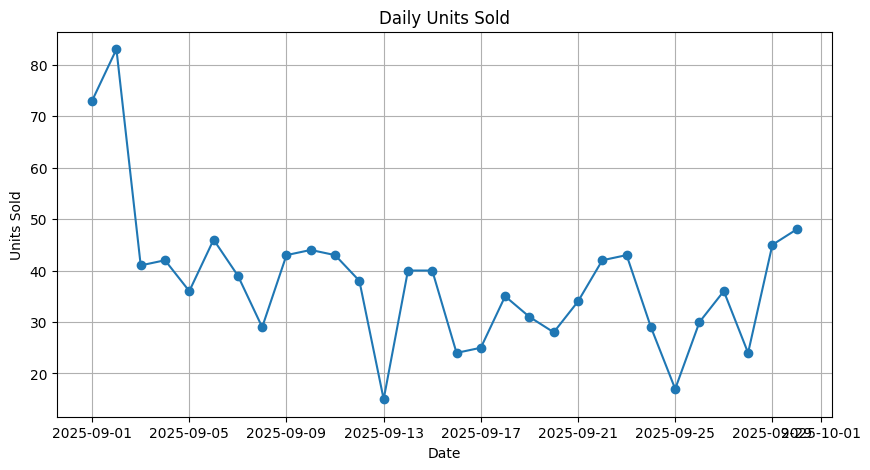

In [16]:
plt.figure(figsize=(10,5))
plt.plot(df['Date Range'], df['Units Sold'], marker='o')
plt.title("Daily Units Sold")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.grid(True)
plt.show()

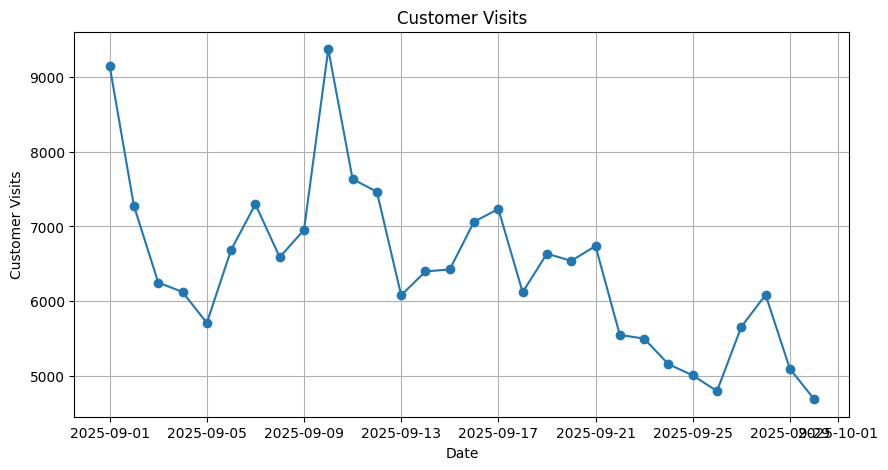

In [17]:
plt.figure(figsize=(10,5))
plt.plot(df['Date Range'], df['Customer Visits'], marker='o')
plt.title("Customer Visits")
plt.xlabel("Date")
plt.ylabel("Customer Visits")
plt.grid(True)
plt.show()

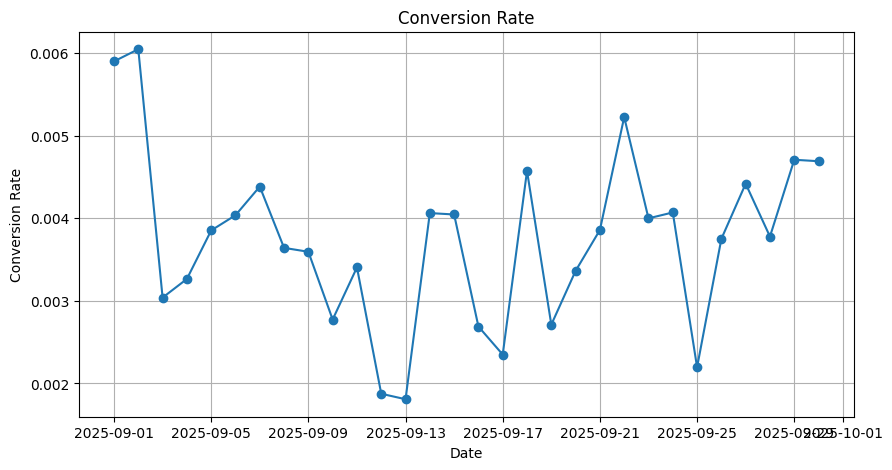

In [18]:
plt.figure(figsize=(10,5))
plt.plot(df['Date Range'], df['Conversion Rate'], marker='o')
plt.title("Conversion Rate")
plt.xlabel("Date")
plt.ylabel("Conversion Rate")
plt.grid(True)
plt.show()

### Correlation Heatmap

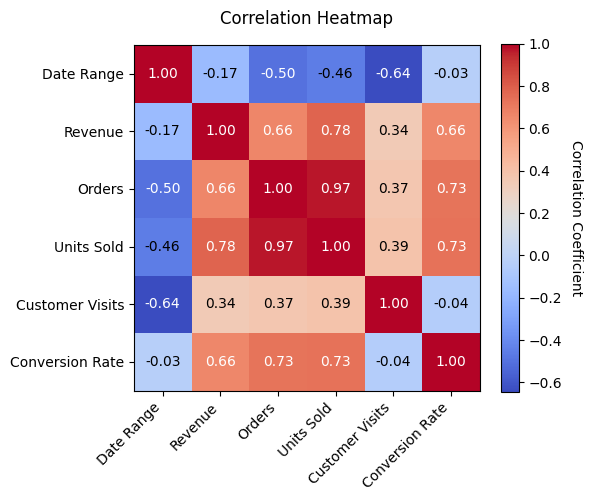

In [19]:
corr = df.corr()

# Plot correlation heatmap
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(corr, cmap='coolwarm', interpolation='nearest')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Correlation Coefficient', rotation=270, labelpad=15)

# Set ticks and labels
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha='right')
ax.set_yticklabels(corr.columns)

# Annotate correlation values
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        ax.text(j, i, f"{corr.iloc[i, j]:.2f}",
                ha='center', va='center',
                color='white' if abs(corr.iloc[i, j]) > 0.5 else 'black')

ax.set_title('Correlation Heatmap', pad=15)
plt.tight_layout()
plt.show()

### Train-Test Split

In [27]:
df = df[['Date Range', 'Units Sold', 'Customer Visits', 'Conversion Rate']].rename(columns={'Date Range': 'ds', 'Units Sold': 'y'})

In [ ]:
## Train-test Split

train = df.iloc[:25]
test = df.iloc[25:]

### Fit ARIMA Model

In [38]:
## Train-test Split

train_arima = train[['ds', 'y']].set_index('ds')
test_arima = test[['ds', 'y']].reset_index(drop=True)

In [39]:
# Fit ARIMA model
arima_model = ARIMA(train_arima, order=(1,1,1))
arima_model_fit = arima_model.fit()

# Summary
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   25
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -94.943
Date:                Thu, 16 Oct 2025   AIC                            195.886
Time:                        15:29:58   BIC                            199.420
Sample:                    09-01-2025   HQIC                           196.823
                         - 09-25-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3296      0.606      0.544      0.586      -0.858       1.517
ma.L1         -0.7127      0.498     -1.432      0.152      -1.688       0.262
sigma2       157.9199     37.820      4.176      0.0

/home/fm-pc-lt-238/miniconda3/envs/demand/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/fm-pc-lt-238/miniconda3/envs/demand/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/fm-pc-lt-238/miniconda3/envs/demand/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/fm-pc-lt-238/miniconda3/envs/demand/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [81]:
# Forecast for next 5 days
forecast = arima_model_fit.forecast(steps=len(test_arima))

# Combine results
results_arima = test_arima.copy()
results_arima['arima'] = forecast.values

results_arima

,ds,y,arima
0,2025-09-26,30,23.783483
1,2025-09-27,36,26.019326
2,2025-09-28,24,26.756262
3,2025-09-29,45,26.999157
4,2025-09-30,48,27.079216


In [82]:
### Evaluate ARIMA Performance

# Actual and predicted
y_true = results_arima['y']
y_pred = results_arima['arima']

# Metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
rmsle = np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))

arima_metrics_df = pd.DataFrame({
    'MAE': [mae],
    'RMSE': [rmse],
    'RMSLE': [rmsle]
}, index=['ARIMA'])

arima_metrics_df

,MAE,RMSE,RMSLE
ARIMA,11.575016,13.472679,0.37851


### Fit SARIMAX Model

In [70]:
train_y = train["y"]
train_exog = train[["Customer Visits", "Conversion Rate"]]

test_y = test["y"]
test_exog = test[["Customer Visits", "Conversion Rate"]]

In [71]:
# Fit SARIMAX model
sarimax_model = SARIMAX(train_y, order=(1,1,1), seasonal_order=(0,0,0,0))
sarimax_fit = sarimax_model.fit(disp=False)

# Summary
print(sarimax_fit.summary())

# Fit SARIMAX model
sarimax_model_exog_feat = SARIMAX(train_y, exog=train_exog, order=(1,1,1), seasonal_order=(0,0,0,0))
sarimax_exog_fit = sarimax_model_exog_feat.fit(disp=False)

# Summary
print(sarimax_exog_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   25
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -94.943
Date:                Thu, 16 Oct 2025   AIC                            195.886
Time:                        16:20:35   BIC                            199.420
Sample:                             0   HQIC                           196.823
                                 - 25                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3296      0.606      0.544      0.586      -0.858       1.517
ma.L1         -0.7127      0.498     -1.432      0.152      -1.688       0.262
sigma2       157.9199     37.820      4.176      0.0

/home/fm-pc-lt-238/miniconda3/envs/demand/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [84]:
forecast = sarimax_fit.forecast(steps=len(test_y))
forecast_exog = sarimax_exog_fit.forecast(steps=len(test_y), exog=test_exog)

# Combine actual vs predicted
results_sarimax = test_y.copy()
results_sarimax = pd.DataFrame({'ds': test["ds"],'y': test_y, 'sarima': forecast.values, 'sarima_exog': forecast_exog.values}).reset_index(drop=True)
results_sarimax

,ds,y,sarima,sarima_exog
0,2025-09-26,30,23.783483,28.324431
1,2025-09-27,36,26.019326,37.697730
2,2025-09-28,24,26.756262,34.394271
3,2025-09-29,45,26.999157,37.525050
4,2025-09-30,48,27.079216,35.554350


In [ ]:
### Evaluate SARIMAX Performance (Exog: None)

y_true = results_sarimax['y']
y_pred = results_sarimax['sarima']

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
rmsle = np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))


### Evaluate SARIMAX Performance (Exog: Customer Visits, Conversion Rate)

y_true = results_sarimax['y']
y_pred = results_sarimax['sarima_exog']

mae_exog = mean_absolute_error(y_true, y_pred)
rmse_exog = np.sqrt(mean_squared_error(y_true, y_pred))
rmsle_exog = np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))

sarimax_metrics_df = pd.DataFrame({
    'MAE': [mae, mae_exog],
    'RMSE': [rmse, rmse_exog],
    'RMSLE': [rmsle, rmsle_exog]
}, index=['SARIMAX', "SARIMAX_with_exog_feat"])

sarimax_metrics_df

,MAE,RMSE,RMSLE
SARIMAX,11.575016,13.472679,0.378510
SARIMAX_with_exog_feat,6.737634,8.056051,0.220583


## Fit Prophet model

In [66]:
# Initialize and fit prophet
prophet_model = Prophet()
prophet_model.add_seasonality(name="weekly", period=7, fourier_order=2)
prophet_model.fit(train)

prophet_model_extra_feat = Prophet() # default seasonality of fourier_order=3
prophet_model_extra_feat.add_seasonality(name="weekly", period=7, fourier_order=2)
prophet_model_extra_feat.add_regressor('Customer Visits')
prophet_model_extra_feat.add_regressor('Conversion Rate')
prophet_model_extra_feat.fit(train)

16:03:56 - cmdstanpy - INFO - Chain [1] start processing
16:03:57 - cmdstanpy - INFO - Chain [1] done processing
16:03:57 - cmdstanpy - INFO - Chain [1] start processing
16:03:57 - cmdstanpy - INFO - Chain [1] done processing


In [80]:
future_test = prophet_model.make_future_dataframe(periods=len(test), freq='D')
forecast_test = prophet_model.predict(future_test)

# Keep only test period predictions
predictions = forecast_test[['ds', 'yhat']].iloc[-len(test):]
predictions.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

# Combine actual vs predicted
prophet_results = test.copy()
prophet_results['prophet'] = predictions['yhat']



future_test = prophet_model_extra_feat.make_future_dataframe(periods=len(test), freq='D')[-len(test):]
future_test.reset_index(drop=True, inplace=True)
future_test["Customer Visits"] = test["Customer Visits"]
future_test["Conversion Rate"] = test["Conversion Rate"]
forecast_extra_feat = prophet_model_extra_feat.predict(future_test)

# Keep only test period predictions
predictions = forecast_extra_feat[['ds', 'yhat']].iloc[-len(test):]
predictions.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

prophet_results['prophet_exog'] = predictions['yhat']
prophet_results

,ds,y,Customer Visits,Conversion Rate,prophet,prophet_exog
0,2025-09-26,30,4798,0.003752,19.318715,29.400671
1,2025-09-27,36,5657,0.004419,15.220543,34.689097
2,2025-09-28,24,6086,0.003779,19.544721,22.616925
3,2025-09-29,45,5096,0.004710,28.580134,31.552307
4,2025-09-30,48,4689,0.004692,26.304370,36.050673


In [ ]:
# Actual and predicted values
y_true = prophet_results['y']
y_pred = prophet_results['prophet']
y_pred_extra_feat = prophet_results['prophet_exog']

# Metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
rmsle = np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))

# Metrics Extra Feature
mae_extra_feat = mean_absolute_error(y_true, y_pred_extra_feat)
rmse_extra_feat = np.sqrt(mean_squared_error(y_true, y_pred_extra_feat))
rmsle_extra_feat = np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred_extra_feat)))

prophet_metrics_df = pd.DataFrame({
    'MAE': [mae, mae_extra_feat],
    'RMSE': [rmse, rmse_extra_feat],
    'RMSLE': [rmsle, rmsle_extra_feat]
}, index=['Prophet', 'Prophet_with_exog_feat'])

prophet_metrics_df

,MAE,RMSE,RMSLE
Prophet,14.806304,16.161916,0.535524
Prophet_with_exog_feat,5.738066,8.094658,0.201312


In [98]:
metrics_df = pd.concat([arima_metrics_df, sarimax_metrics_df, prophet_metrics_df])
metrics_df.drop(["RMSLE"], axis=1)

,MAE,RMSE
ARIMA,11.575016,13.472679
SARIMAX,11.575016,13.472679
SARIMAX_with_exog_feat,6.737634,8.056051
Prophet,14.806304,16.161916
Prophet_with_exog_feat,5.738066,8.094658


In [87]:
prediction_results_df = (
    results_arima
    .merge(results_sarimax, on=['ds', 'y'], how='inner')
    .merge(prophet_results, on=['ds', 'y'], how='inner')
)

prediction_results_df.drop(["Customer Visits", "Conversion Rate"], axis=1, inplace=True)

In [92]:
prediction_results_df

,ds,y,arima,sarima,sarima_exog,prophet,prophet_exog
0,2025-09-26,30,23.783483,23.783483,28.324431,19.318715,29.400671
1,2025-09-27,36,26.019326,26.019326,37.697730,15.220543,34.689097
2,2025-09-28,24,26.756262,26.756262,34.394271,19.544721,22.616925
3,2025-09-29,45,26.999157,26.999157,37.525050,28.580134,31.552307
4,2025-09-30,48,27.079216,27.079216,35.554350,26.304370,36.050673


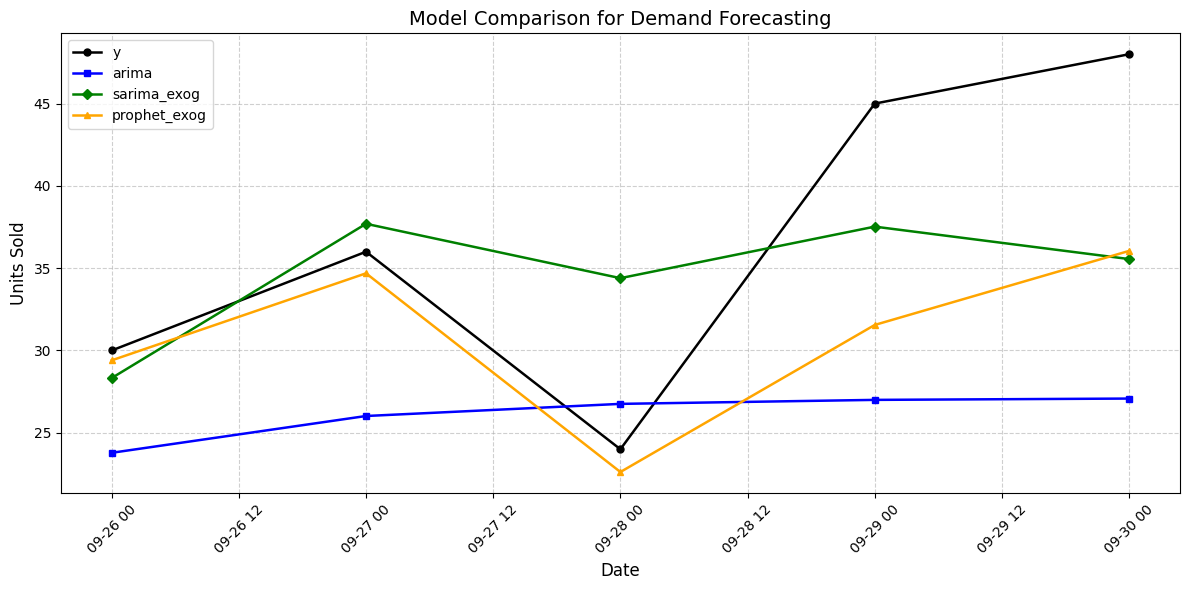

In [97]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'ds' is datetime
prediction_results_df['ds'] = pd.to_datetime(prediction_results_df['ds'])

# Set figure size
plt.figure(figsize=(12, 6))

# Define line styles and markers
markers = ['o', 's', 'D', '^', 'v', 'P', '*']
colors = ['black', 'blue', 'green', 'orange', 'red', 'purple', 'brown']
# columns = ['y', 'arima', 'sarima', 'sarima_exog', 'prophet', 'prophet_exog']
columns = ['y', 'arima', 'sarima_exog', 'prophet_exog']


# Plot each curve with unique color and marker
for i, col in enumerate(columns):
    plt.plot(
        prediction_results_df['ds'],
        prediction_results_df[col],
        label=col,
        marker=markers[i % len(markers)],
        color=colors[i % len(colors)],
        markersize=5,
        linewidth=1.8
    )

# Labels and formatting
plt.xlabel('Date', fontsize=12)
plt.ylabel('Units Sold', fontsize=12)
plt.title('Model Comparison for Demand Forecasting', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()
